In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import time
from models import MLP
from get_embedded_data import get_data_tokenizer_MLP, split_data, MAPPING


c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginn

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
from transformers import BertModel, ElectraModel, RobertaModel
from transformers import BertTokenizer, ElectraTokenizer, RobertaTokenizer


bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

robert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
robert_model = RobertaModel.from_pretrained('roberta-base')

electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
electra_model = ElectraModel.from_pretrained('google/electra-small-discriminator')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def train_one_ROBERTA(max_epoch, network, train_dataloader, test_dataloader, optimizer, criterion, device):
    train_data_df = []
    f1_score_train = []
    f1_score_test = []


    network.train()
    best_network = network
    best_accuracy = 0
    dict_for_stat = {
        0: [0,0,0],
        1: [0,0,0],
        2: [0,0,0],
        3: [0,0,0],
        4: [0,0,0],
        5: [0,0,0],
        6: [0,0,0],
        7: [0,0,0],
        8: [0,0,0]
    }
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    for epoch in range(max_epoch):

        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            inputs = torch.flatten(inputs.double(), 1)
            outputs = network(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            for pr, lab in zip(predicted, labels):
                pr, lab = pr.item(), lab.item()
                if pr == lab:
                    # TP
                    dict_for_stat[pr][0] += 1
                    continue
                # FN
                dict_for_stat[lab][1] += 1
                # FP
                dict_for_stat[pr][2] += 1

            running_loss += loss.item()
        print(f"{epoch}, {loss}")
        running_loss = 0.0

        pr_rec_f1 = {}
        for key in dict_for_stat.keys():
            tp, fn, fp = dict_for_stat[key]
            precision = -1 if tp+fp == 0 else tp/(tp+fp)
            recall = -1 if tp+fn == 0 else tp/(tp+fn)
            f1_score = -1 if tp+fn+fp == 0 else 2*tp/(2*tp+fn+fp)
            pr_rec_f1[key] = [precision, recall, f1_score]

        running_f1_score = 0
        for key in dict_for_stat.keys():
            running_f1_score += pr_rec_f1[key][2]
        running_f1_score /= len(dict_for_stat.keys())
        f1_score_train.append(running_f1_score)

        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        network.eval()
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            x_len = [len(input) for input in inputs]
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = torch.flatten(inputs.double(), 1)
            outputs = network(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            for pr, lab in zip(predicted, labels):
                pr, lab = pr.item(), lab.item()
                if pr == lab:
                    # TP
                    dict_for_stat[pr][0] += 1
                    continue
                # FN
                dict_for_stat[lab][1] += 1
                # FP
                dict_for_stat[pr][2] += 1

        pr_rec_f1 = {}
        for key in dict_for_stat.keys():
            tp, fn, fp = dict_for_stat[key]
            precision = -1 if tp+fp == 0 else tp/(tp+fp)
            recall = -1 if tp+fn == 0 else tp/(tp+fn)
            f1_score = -1 if tp+fn+fp == 0 else 2*tp/(2*tp+fn+fp)
            pr_rec_f1[key] = [precision, recall, f1_score]

        running_f1_score = 0
        for key in dict_for_stat.keys():
            running_f1_score += pr_rec_f1[key][2]
        running_f1_score /= len(dict_for_stat.keys())
        f1_score_test.append(running_f1_score)

    # final_accuracy = round(100 * correct / total, 3)

    return best_network, 0, best_accuracy, all_labels, all_predictions, pr_rec_f1, pd.DataFrame(train_data_df, columns=["Epoch", "Max Epoch", "loss", "train data accuracy", "test data accuracy"]),f1_score_train,f1_score_test

In [34]:
models_list = ("roberta", robert_tokenizer, robert_model)
weigths = None

full_data = []
X_train, X_test, y_train, y_test = split_data("data_set.csv", "author", "quote", test_size=0.2, separator="@", mapping=MAPPING,
                                            labels_to_delete=[])
name, tokenizer, model = models_list
train_dataloader, shape = get_data_tokenizer_MLP(batch=20*5, words=X_train, labels=y_train, device=device, tokenizer=tokenizer, model=model)
test_dataloader, shape = get_data_tokenizer_MLP(batch=1, words=X_test, labels=y_test, device=device, tokenizer=tokenizer, model=model)
network = MLP(shape*125, 125*2, 125, 9, dropout=0).to(device)
criterion = nn.CrossEntropyLoss(weight=weigths)
optimizer = optim.Adam(network.parameters())

['aristotle' 'freud' 'hegel' 'kant' 'nietzsche' 'plato' 'sartre'
 'schopenhauer' 'spinoza']


c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
best_network, test_acc, best_accuracy, all_labels, all_predictions, pr_rec_f1, train_data,f1_score_train,f1_score_test = train_one_ROBERTA(max_epoch=40, network=network, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, criterion=criterion, device=device)

0, 0.0010285592556285373
1, 0.0009377096800597699
2, 0.000740954746365866
3, 0.0007947354022294051
4, 0.0009205025540201786
5, 0.0006639396089572897
6, 0.0004880279962331149
7, 0.0003766187264712973
8, 0.0005623312034354253
9, 0.000529808952329927
10, 0.0005377466489530815
11, 0.0006116862181087243
12, 0.00046257013169173107
13, 0.000461844593707238
14, 0.0004413444599455011
15, 0.0004513794110219288
16, 0.00032439255474226857
17, 0.0004501137170379172
18, 0.0004723933842396163
19, 0.00033506269334044567
20, 0.00028808044200233146
21, 0.00037430474601610794
22, 0.0003079550035448085
23, 0.00038411667758059677
24, 0.0002453514926452335
25, 0.00037160886424861326
26, 0.00026651190011134807
27, 0.00026613477228424747
28, 0.00024340161164632687
29, 0.00028834257139729013
30, 0.00031464174411806165
31, 0.0002610144577133979
32, 0.00028458713365681813
33, 0.0002637299779949818
34, 0.00019712140526843364
35, 0.000166502544076571
36, 0.0001721079070650214
37, 0.00016956486253255062
38, 0.00021

In [41]:
print(f1_score_test)

[0.8672915922453066, 0.8677526577563767, 0.8680800704412621, 0.8682221776101492, 0.868005844151868, 0.8678880482148484, 0.8680763975239875, 0.8679881130404701, 0.8679227972844088, 0.8676299464256841, 0.8675512510197051, 0.86758671784618, 0.8675013703109177, 0.8675048352229353, 0.8675399661545637, 0.8674664610504029, 0.8675010900684489, 0.8674888159116032, 0.8674669685309889, 0.8674652507239851, 0.8674788241588615, 0.8675023243807479, 0.8675462907850288, 0.8675767939599175, 0.8675700550210098, 0.8675999275125742, 0.8676309125838597, 0.8676467036913825, 0.8676685354123391, 0.8676841980022373, 0.8677424568972032, 0.8677388361059548, 0.8677669472635743, 0.8677675735249301, 0.8677510461526273, 0.8677769587989871, 0.8678161043569556, 0.8678524382807846, 0.8678641992445969, 0.8678815466586726]


In [42]:
print(f1_score_train)

[1.0, 0.9264609924008498, 0.9057547514772956, 0.8959441098535359, 0.8901534677474674, 0.8861557125005898, 0.8835750729911847, 0.8816582608816748, 0.8800156929178543, 0.8787356281176923, 0.8774732994893591, 0.8765532897704345, 0.8758890355859514, 0.8752307119756905, 0.874699252271033, 0.874264716411217, 0.8737958009275654, 0.87346701548443, 0.8731604091873547, 0.8728344253322465, 0.8726076886337997, 0.8723689787131267, 0.8721719601690937, 0.8720398345224589, 0.871871562123441, 0.8716919546159202, 0.8715812217369587, 0.8714742714166983, 0.8713340047090542, 0.8712365241100387, 0.8711513895820278, 0.8710595998951866, 0.8709809898435354, 0.8709091134321546, 0.8707963660297713, 0.8707265837825114, 0.870672945228184, 0.8706204959572087, 0.8705861505332931, 0.8705275839607437]


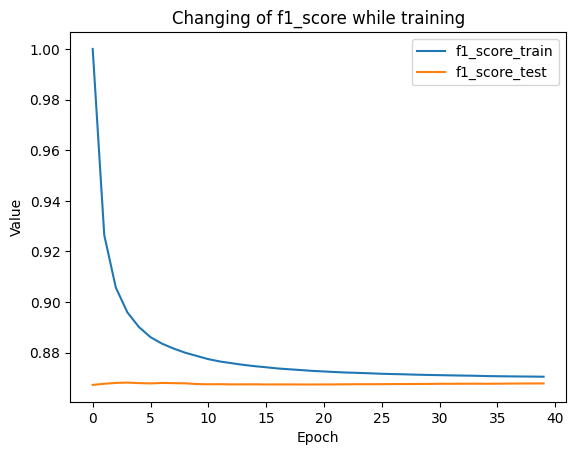

In [43]:
import matplotlib.pyplot as plt

plt.plot(f1_score_train)
plt.plot(f1_score_test)
plt.legend(['f1_score_train', 'f1_score_test'])
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Changing of f1_score while training')
plt.savefig('learning_plot_2.png')
plt.show()

In [4]:
def train(max_epoch, network, train_dataloader, test_dataloader, optimizer, criterion):
    train_data_df = []

    network.train()
    best_network = network
    best_accuracy = 0
    dict_for_stat = {
        0: [0,0,0],
        1: [0,0,0],
        2: [0,0,0],
        3: [0,0,0],
        4: [0,0,0],
        5: [0,0,0],
        6: [0,0,0],
        7: [0,0,0],
        8: [0,0,0]
    }
    for epoch in range(max_epoch):

        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            inputs = torch.flatten(inputs.double(), 1)
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()


        val_correct = 0
        val_total = 0
        for i, val_data in enumerate(test_dataloader, 0):
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_inputs = torch.flatten(val_inputs.double(), 1)
            val_outputs = network(val_inputs)

            val_total += val_labels.size(0)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct += (val_predicted == val_labels).sum().item()
        if round(100 * val_correct / val_total, 3) > best_accuracy:
            best_accuracy = round(100 * val_correct / val_total, 3)
            best_network = copy.deepcopy(network)

        train_loss = running_loss / 2000
        train_accuracy = round(100 * correct / total, 3)
        val_accuracy = round(100 * val_correct / val_total, 3)
        train_data_df.append([epoch+1, max_epoch, round(train_loss, 3), train_accuracy, val_accuracy])

        running_loss = 0.0

    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    start_time = time.time()
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = torch.flatten(inputs.double(), 1)
        outputs = best_network(inputs)


        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        for pr, lab in zip(predicted, labels):
            pr, lab = pr.item(), lab.item()
            if pr == lab:
                # TP
                dict_for_stat[pr][0] += 1
                continue
            # FN
            dict_for_stat[lab][1] += 1
            # FP
            dict_for_stat[pr][2] += 1
    pred_time = start_time - time.time()

    pr_rec_f1 = {}
    for key in dict_for_stat.keys():
        tp, fn, fp = dict_for_stat[key]
        precision = -1 if tp+fp == 0 else tp/(tp+fp)
        recall = -1 if tp+fn == 0 else tp/(tp+fn)
        f1_score = -1 if tp+fn+fp == 0 else 2*tp/(2*tp+fn+fp)
        pr_rec_f1[key] = [precision, recall, f1_score]

    final_accuracy = round(100 * correct / total, 3)

    return best_network, final_accuracy, best_accuracy, all_labels, all_predictions, pr_rec_f1, pred_time, pd.DataFrame(train_data_df, columns=["Epoch", "Max Epoch", "loss", "train data accuracy", "test data accuracy"])


In [5]:
models_list = [("bert", bert_tokenizer, bert_model), ("roberta", robert_tokenizer, robert_model), ("electra", electra_tokenizer, electra_model)]
labels_to_delete_list = [[], ['spinoza', "hegel", "plato"], ['aristotle', 'freud', 'kant', 'nietzsche', 'sartre', 'schopenhauer']]
weigth_list = [None, torch.tensor([1,1,2,3,1.33,1.33,5,1,2.5],dtype=torch.double).to(device)]

full_data = []
for labels_to_delete in labels_to_delete_list:
    X_train, X_test, y_train, y_test = split_data("data_set.csv", "author", "quote", test_size=0.2, separator="@", mapping=MAPPING,
                                                labels_to_delete=labels_to_delete)
    for name, tokenizer, model in models_list:
        train_dataloader, shape = get_data_tokenizer_MLP(batch=20*5, words=X_train, labels=y_train, device=device, tokenizer=tokenizer, model=model)
        test_dataloader, shape = get_data_tokenizer_MLP(batch=1, words=X_test, labels=y_test, device=device, tokenizer=tokenizer, model=model)
        for weigths in weigth_list:
            network = MLP(shape*125, 125*2, 125, 9, dropout=0).to(device)
            criterion = nn.CrossEntropyLoss(weight=weigths)
            optimizer = optim.Adam(network.parameters())
            best_network, test_acc, best_accuracy, all_labels, all_predictions, pr_rec_f1, pred_time, train_data = train(max_epoch=20, network=network, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, criterion=criterion)
            weigths = [] if weigths is None else [1,1,2,3,1.33,1.33,5,1,2.5]
            torch.save(best_network, f"train_models/{name}_{labels_to_delete}_{weigths}.pt")
            train_data.to_csv(f"train_data/{name}_{labels_to_delete}_{weigths}.csv")
            full_data.append([name, labels_to_delete, weigths, test_acc, best_accuracy, all_labels, all_predictions, pr_rec_f1, pred_time])
full_data_df = pd.DataFrame(full_data, columns=["name", "labels_to_delete", "weigths", "test_acc", "best_accuracy", "all_labels", "all_predictions", "pr_rec_f1", "pred_time"])
full_data_df.to_csv("train_data/full_data.csv")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['aristotle' 'freud' 'hegel' 'kant' 'nietzsche' 'plato' 'sartre'
 'schopenhauer' 'spinoza']


c:\Users\kwarc\PycharmProjects\NLP\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific 

In [6]:
# cm = confusion_matrix([[MAPPING[x] for x in all_labels], [MAPPING[x] for x in all_predictions])

# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()